## 1. Setup and Installation

In [ ]:
# ============================================================
# 🚀 GOOGLE COLAB SETUP - Run this cell first!
# ============================================================
# If running on Google Colab, uncomment and run the lines below.
# Binder users: packages are automatically installed from requirements.txt

# !pip install -q -r https://raw.githubusercontent.com/arunissun/Montandon-Data-Fetching-Examples/master/requirements.txt

# # Set your API token (you'll be prompted to enter it securely)
# import os
# from getpass import getpass
# if 'MONTANDON_API_TOKEN' not in os.environ:
#     os.environ['MONTANDON_API_TOKEN'] = getpass('Enter your Montandon API token: ')

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pystac_client import Client
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose
import pymannkendall as mk
import warnings
import time
import os
import csv
import gc
from getpass import getpass

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## 2. Configuration: Region, Time Period, and Hazard Codes

In [2]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# South Asia Bounding Box [min_lon, min_lat, max_lon, max_lat]
# Covers: Pakistan, India, Bangladesh, Nepal, Sri Lanka, Bhutan, Maldives
SOUTH_ASIA_BBOX = [60, 5, 100, 37]

# Time Period: Last 10 years
END_DATE = datetime(2024, 6, 30)
START_DATE = END_DATE - relativedelta(years=10)

# Collections to search
COLLECTIONS = ['gdacs-events', 'emdat-events', 'glide-events']

# ============================================================================
# HAZARD CODES (Based on official Montandon taxonomy)
# Source: https://ifrcgo.org/monty-stac-extension/model/taxonomy/
# ============================================================================

# FLOOD HAZARD CODES
# - GLIDE: FL (Flood), FF (Flash Flood)
# - EM-DAT: nat-hyd-flo-* (Hydrological Floods)
# - UNDRR-ISC 2025: MH06XX (Water-related/Flooding)
FLOOD_CODES = [
    # GLIDE codes
    "FL",                    # Flood
    "FF",                    # Flash Flood
    
    # UNDRR-ISC 2025 codes (MH06XX = Water-related/Flooding cluster)
    "MH0600",                # Flooding (Chapeau/General)
    "MH0601",                # Coastal Flooding
    "MH0602",                # Estuarine (Coastal) Flooding
    "MH0603",                # Flash Flooding
    "MH0604",                # Fluvial (Riverine) Flooding
    
    "MH0606",                # Surface water Flooding
    "MH0607",                # Glacial Lake Outburst Flooding
    
    # EM-DAT CRED codes
    "nat-hyd-flo-flo",       # Flood (General)
    "nat-hyd-flo-fla",       # Flash flood
    "nat-hyd-flo-riv",       # Riverine flood
    "nat-hyd-flo-coa",       # Coastal flood
    "nat-hyd-flo-ice",       # Ice jam flood
    "nat-cli-glo-glo",       # Glacial lake outburst flood
]

# CYCLONE HAZARD CODES
# - GLIDE: TC (Tropical Cyclone), EC (Extra-tropical Cyclone)
# - EM-DAT: nat-met-sto-tro (Tropical cyclone), nat-met-sto-ext (Extra-tropical)
# - UNDRR-ISC 2025: MH03XX (Wind & Pressure-related)
CYCLONE_CODES = [
    # GLIDE codes
    "TC",                    # Tropical Cyclone
    "EC",                    # Extra-tropical Cyclone
    
    # UNDRR-ISC 2025 codes (MH03XX = Wind & Pressure-related cluster)
    "MH0306",                # Depression or Cyclone
    "MH0307",                # Extra-tropical Cyclone
    "MH0308",                # Sub-tropical Cyclone
    "MH0309",                # Tropical Cyclone
    
    # EM-DAT CRED codes
    "nat-met-sto-tro",       # Tropical cyclone
    "nat-met-sto-ext",       # Extra-tropical storm
]

print("="*70)
print("CONFIGURATION SUMMARY")
print("="*70)
print(f"Region: South Asia (bbox: {SOUTH_ASIA_BBOX})")
print(f"Time Period: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print(f"Collections: {COLLECTIONS}")
print(f"\nFlood codes: {len(FLOOD_CODES)} codes")
print(f"Cyclone codes: {len(CYCLONE_CODES)} codes")
print("="*70)

CONFIGURATION SUMMARY
Region: South Asia (bbox: [60, 5, 100, 37])
Time Period: 2014-06-30 to 2024-06-30
Collections: ['gdacs-events', 'emdat-events', 'glide-events']

Flood codes: 15 codes
Cyclone codes: 8 codes


## 3. Connect to Montandon STAC API

In [3]:
# ============================================================================
# AUTHENTICATION & CONNECTION TO MONTANDON STAC API
# ============================================================================

STAC_API_URL = "https://montandon-eoapi-stage.ifrc.org/stac"

# Get authentication token
api_token = os.getenv('MONTANDON_API_TOKEN')

if api_token is None:
    print("=" * 70)
    print("AUTHENTICATION REQUIRED")
    print("=" * 70)
    print("\nThe Montandon STAC API requires a Bearer Token for authentication.")
    print("\nHow to get your token:")
    print("  1. Visit: https://goadmin-stage.ifrc.org/")
    print("  2. Log in with your IFRC credentials")
    print("  3. Generate an API token from your account settings")
    print("\n" + "=" * 70)
    api_token = getpass("Enter your Montandon API Token: ")

# Create authentication headers
auth_headers = {"Authorization": f"Bearer {api_token}"}

# Connect to STAC API
try:
    client = Client.open(STAC_API_URL, headers=auth_headers)
    print(f"\n Connected to: {STAC_API_URL}")
    print(f" API Title: {client.title}")
    print(f" Authentication: Bearer Token (OpenID Connect)")
except Exception as e:
    print(f"\n Authentication failed: {e}")
    raise

AUTHENTICATION REQUIRED

The Montandon STAC API requires a Bearer Token for authentication.

How to get your token:
  1. Visit: https://goadmin-stage.ifrc.org/
  2. Log in with your IFRC credentials
  3. Generate an API token from your account settings


 Connected to: https://montandon-eoapi-stage.ifrc.org/stac
 API Title: stac-fastapi
 Authentication: Bearer Token (OpenID Connect)

 Connected to: https://montandon-eoapi-stage.ifrc.org/stac
 API Title: stac-fastapi
 Authentication: Bearer Token (OpenID Connect)


## 4. CQL2-JSON Filter Builder Functions

Using the official Montandon queryables specification:
- `a_overlaps`: Find events where hazard codes overlap with our target codes
- `t_during`: Filter by datetime interval
- `s_intersects`: Spatial filter by bounding box

In [5]:
# ============================================================================
# CQL2-JSON FILTER BUILDERS
# Based on: https://ifrcgo.org/monty-stac-extension/model/stac-api/queryables/
# ============================================================================

def build_datetime_filter(start_date: str, end_date: str) -> dict:
    """
    Build CQL2 JSON filter for datetime range using t_during.
    """
    return {
        "op": "t_during",
        "args": [
            {"property": "datetime"},
            {"interval": [start_date, end_date]}
        ]
    }

def build_bbox_filter(bbox: list) -> dict:
    """
    Build CQL2 JSON filter for bounding box using s_intersects.
    bbox format: [min_lon, min_lat, max_lon, max_lat]
    """
    return {
        "op": "s_intersects",
        "args": [
            {"property": "geometry"},
            {
                "type": "Polygon",
                "coordinates": [[
                    [bbox[0], bbox[1]],
                    [bbox[2], bbox[1]],
                    [bbox[2], bbox[3]],
                    [bbox[0], bbox[3]],
                    [bbox[0], bbox[1]]
                ]]
            }
        ]
    }

def build_hazard_filter(hazard_codes: list) -> dict:
    """
    Build CQL2 JSON filter for hazard codes using a_overlaps.
    
    IMPORTANT: Use a_overlaps for array fields, not 'in' operator!
    This finds events where monty:hazard_codes shares at least one element with our codes.
    """
    return {
        "op": "a_overlaps",
        "args": [
            {"property": "monty:hazard_codes"},
            hazard_codes
        ]
    }

def build_combined_filter(
    start_date: str,
    end_date: str,
    bbox: list,
    hazard_codes: list = None
) -> dict:
    """
    Build combined CQL2 JSON filter for datetime, spatial, and hazard constraints.
    
    Example output:
    {
        "op": "and",
        "args": [
            {"op": "t_during", ...},
            {"op": "s_intersects", ...},
            {"op": "a_overlaps", ...}
        ]
    }
    """
    filters = [
        build_datetime_filter(start_date, end_date),
        build_bbox_filter(bbox)
    ]
    
    if hazard_codes:
        filters.append(build_hazard_filter(hazard_codes))
    
    return {
        "op": "and",
        "args": filters
    }

print("✅ CQL2-JSON filter functions initialized")
print("\nExample flood filter structure:")
example_filter = build_combined_filter(
    "2024-01-01T00:00:00Z",
    "2024-12-31T23:59:59Z",
    SOUTH_ASIA_BBOX,
    FLOOD_CODES[:3]  # Just show first 3 codes
)


✅ CQL2-JSON filter functions initialized

Example flood filter structure:


## 5.  Search Function

In [6]:
# ============================================================================
# MEMORY-EFFICIENT SEARCH FUNCTION (Binder-Safe)
# ============================================================================

def search_events_with_cql2(
    collections: list,
    bbox: list,
    start_year: int,
    end_year: int,
    hazard_codes: list,
    output_file: str,
    max_items_per_year: int = 3000
) -> str:
    """
    Search events using CQL2-JSON server-side filtering and stream to CSV.
    
    KEY FEATURES:
    1. Uses a_overlaps for hazard code filtering (correct array operator)
    2. Combines datetime + bbox + hazard in single CQL2 filter
    3. Streams results to CSV year-by-year to save memory
    4. Forces garbage collection after each year
    
    Parameters:
    -----------
    collections : list
        Collection IDs to search (e.g., ['gdacs-events', 'emdat-events'])
    bbox : list
        Bounding box [min_lon, min_lat, max_lon, max_lat]
    start_year : int
        Starting year
    end_year : int
        Ending year
    hazard_codes : list
        List of hazard codes for server-side filtering
    output_file : str
        Output CSV filename
    max_items_per_year : int
        Maximum items to fetch per year
        
    Returns:
    --------
    str: Path to output CSV file
    """
    # Remove existing file
    if os.path.exists(output_file):
        os.remove(output_file)
    
    # CSV headers
    headers = ["id", "datetime", "title", "hazard_codes", "primary_country", "collection"]
    
    # Initialize CSV
    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
    
    print(f"Streaming to {output_file}...")
    print(f"Hazard codes: {hazard_codes[:5]}..." if len(hazard_codes) > 5 else f"Hazard codes: {hazard_codes}")
    total_count = 0
    
    for year in range(start_year, end_year + 1):
        # Build CQL2 filter for this year
        start_date = f"{year}-01-01T00:00:00Z"
        end_date = f"{year}-12-31T23:59:59Z"
        
        cql2_filter = build_combined_filter(
            start_date=start_date,
            end_date=end_date,
            bbox=bbox,
            hazard_codes=hazard_codes
        )
        
        yearly_items = []
        
        for collection in collections:
            try:
                # Search with CQL2-JSON filter
                search = client.search(
                    collections=[collection],
                    filter=cql2_filter,
                    filter_lang="cql2-json",
                    max_items=max_items_per_year
                )
                
                items = list(search.items())
                if items:
                    yearly_items.extend(items)
                    
            except Exception as e:
                print(f"   ⚠️ {collection} {year}: {str(e)[:50]}")
        
        # Process and write items
        if yearly_items:
            rows = []
            for item in yearly_items:
                props = item.properties
                dt_str = props.get("datetime") or props.get("start_datetime")
                h_codes = props.get("monty:hazard_codes", [])
                h_codes_str = ";".join(h_codes) if isinstance(h_codes, list) else str(h_codes)
                c_codes = props.get("monty:country_codes", [])
                p_country = c_codes[0] if c_codes else "Unknown"
                
                rows.append([
                    item.id,
                    dt_str,
                    props.get("title", ""),
                    h_codes_str,
                    p_country,
                    item.collection_id
                ])
            
            # Append to CSV
            with open(output_file, 'a', newline='', encoding='utf-8') as f:
                writer = csv.writer(f)
                writer.writerows(rows)
            
            total_count += len(rows)
            print(f"   {year}: {len(rows)} events (Total: {total_count})")
        else:
            print(f"   {year}: 0 events")
        
        # Cleanup
        del yearly_items
        gc.collect()
    
    print(f"\n✅ Finished! Total events saved: {total_count}")
    return output_file

print("✅ Search function initialized")

✅ Search function initialized


## 6. Fetch Flood Events

In [7]:
# ============================================================================
# FETCH FLOOD EVENTS (SERVER-SIDE FILTERED)
# ============================================================================

print("=" * 70)
print("FETCHING FLOOD EVENTS (CQL2-JSON SERVER-SIDE FILTERING)")
print("=" * 70)

start_time = time.time()

floods_csv = search_events_with_cql2(
    collections=COLLECTIONS,
    bbox=SOUTH_ASIA_BBOX,
    start_year=START_DATE.year,
    end_year=END_DATE.year,
    hazard_codes=FLOOD_CODES,
    output_file="floods_south_asia.csv"
)

elapsed = time.time() - start_time
print(f"\nTime: {elapsed:.1f} seconds")
print("=" * 70)

FETCHING FLOOD EVENTS (CQL2-JSON SERVER-SIDE FILTERING)
Streaming to floods_south_asia.csv...
Hazard codes: ['FL', 'FF', 'MH0600', 'MH0601', 'MH0602']...
   2014: 66 events (Total: 66)
   2014: 66 events (Total: 66)
   2015: 59 events (Total: 125)
   2015: 59 events (Total: 125)
   2016: 64 events (Total: 189)
   2016: 64 events (Total: 189)
   2017: 45 events (Total: 234)
   2017: 45 events (Total: 234)
   2018: 36 events (Total: 270)
   2018: 36 events (Total: 270)
   2019: 63 events (Total: 333)
   2019: 63 events (Total: 333)
   2020: 82 events (Total: 415)
   2020: 82 events (Total: 415)
   2021: 88 events (Total: 503)
   2021: 88 events (Total: 503)
   2022: 93 events (Total: 596)
   2022: 93 events (Total: 596)
   2023: 109 events (Total: 705)
   2023: 109 events (Total: 705)
   2024: 118 events (Total: 823)

✅ Finished! Total events saved: 823

Time: 134.2 seconds
   2024: 118 events (Total: 823)

✅ Finished! Total events saved: 823

Time: 134.2 seconds


## 7. Fetch Cyclone Events

In [8]:
# ============================================================================
# FETCH CYCLONE EVENTS (SERVER-SIDE FILTERED)
# ============================================================================

print("=" * 70)
print("FETCHING CYCLONE EVENTS (CQL2-JSON SERVER-SIDE FILTERING)")
print("=" * 70)

start_time = time.time()

cyclones_csv = search_events_with_cql2(
    collections=COLLECTIONS,
    bbox=SOUTH_ASIA_BBOX,
    start_year=START_DATE.year,
    end_year=END_DATE.year,
    hazard_codes=CYCLONE_CODES,
    output_file="cyclones_south_asia.csv"
)

elapsed = time.time() - start_time
print(f"\nTime: {elapsed:.1f} seconds")
print("=" * 70)

FETCHING CYCLONE EVENTS (CQL2-JSON SERVER-SIDE FILTERING)
Streaming to cyclones_south_asia.csv...
Hazard codes: ['TC', 'EC', 'MH0306', 'MH0307', 'MH0308']...
   2014: 3 events (Total: 3)
   2014: 3 events (Total: 3)
   2015: 4 events (Total: 7)
   2015: 4 events (Total: 7)
   2016: 6 events (Total: 13)
   2016: 6 events (Total: 13)
   2017: 12 events (Total: 25)
   2017: 12 events (Total: 25)
   2018: 6 events (Total: 31)
   2018: 6 events (Total: 31)
   2019: 9 events (Total: 40)
   2019: 9 events (Total: 40)
   2020: 11 events (Total: 51)
   2020: 11 events (Total: 51)
   2021: 10 events (Total: 61)
   2021: 10 events (Total: 61)
   2022: 4 events (Total: 65)
   2022: 4 events (Total: 65)
   2023: 16 events (Total: 81)
   2023: 16 events (Total: 81)
   2024: 21 events (Total: 102)

✅ Finished! Total events saved: 102

Time: 31.1 seconds
   2024: 21 events (Total: 102)

✅ Finished! Total events saved: 102

Time: 31.1 seconds


## 8. Load Data into DataFrames

In [9]:
# ============================================================================
# LOAD DATA INTO DATAFRAMES
# ============================================================================

def load_events_csv(filepath: str) -> pd.DataFrame:
    """Load events CSV into DataFrame with proper parsing."""
    if not os.path.exists(filepath):
        print(f"❌ File not found: {filepath}")
        return pd.DataFrame()
    
    df = pd.read_csv(filepath, parse_dates=["datetime"])
    df['hazard_codes'] = df['hazard_codes'].fillna("").apply(lambda x: x.split(';') if x else [])
    df.set_index("datetime", inplace=True)
    df.sort_index(inplace=True)
    
    return df

# Load floods
df_floods = load_events_csv("floods_south_asia.csv")
print(f"\n📊 FLOODS: {len(df_floods)} events")
if not df_floods.empty:
    print(f"   Date range: {df_floods.index.min()} to {df_floods.index.max()}")
    print(f"   Countries: {df_floods['primary_country'].nunique()}")
    display(df_floods.head())

# Load cyclones
df_cyclones = load_events_csv("cyclones_south_asia.csv")
print(f"\n📊 CYCLONES: {len(df_cyclones)} events")
if not df_cyclones.empty:
    print(f"   Date range: {df_cyclones.index.min()} to {df_cyclones.index.max()}")
    print(f"   Countries: {df_cyclones['primary_country'].nunique()}")
    display(df_cyclones.head())


📊 FLOODS: 823 events
   Date range: 2014-02-06 00:00:00+00:00 to 2024-12-17 01:00:00+00:00
   Countries: 16


,id,title,hazard_codes,primary_country,collection
datetime,,,,,
2014-02-06 00:00:00+00:00,emdat-event-2014-0535-LKA,Riverine flood in Sri Lanka,[nat-hyd-flo-riv],LKA,emdat-events
2014-04-20 00:00:00+00:00,gdacs-event-4136,Flood in Afghanistan,[FL],NaN,gdacs-events
2014-04-22 00:00:00+00:00,emdat-event-2014-0122-TJK,Flash flood in Tajikistan,[nat-hyd-flo-fla],TJK,emdat-events
2014-04-24 00:00:00+00:00,emdat-event-2014-0134-AFG,Flash flood in Afghanistan,[nat-hyd-flo-fla],AFG,emdat-events
2014-04-25 00:00:00+00:00,glide-event-FF-2014-000060-AFG,NaN,"[nat-hyd-flo-fla, FF]",AFG,glide-events



📊 CYCLONES: 102 events
   Date range: 2014-07-18 00:00:00+00:00 to 2024-12-01 00:00:00+00:00
   Countries: 9


,id,title,hazard_codes,primary_country,collection
datetime,,,,,
2014-07-18 00:00:00+00:00,emdat-event-2014-0227-CHN,Storm (Tropical cyclone) in China of July 2014,[nat-met-sto-tro],CHN,emdat-events
2014-10-12 00:00:00+00:00,emdat-event-2014-0392-IND,Storm (Tropical cyclone) in India of October 2014,[nat-met-sto-tro],IND,emdat-events
2014-10-12 00:00:00+00:00,glide-event-TC-2014-000141-IND,NaN,"[nat-met-sto-tro, TC]",IND,glide-events
2015-07-29 00:00:00+00:00,emdat-event-2015-0309-BGD,Storm (Tropical cyclone) in Bangladesh of July...,[nat-met-sto-tro],BGD,emdat-events
2015-07-29 00:00:00+00:00,glide-event-TC-2015-000101-BGD,NaN,"[nat-met-sto-tro, TC]",BGD,glide-events


## 9. Seasonality Analysis


SEASONALITY ANALYSIS


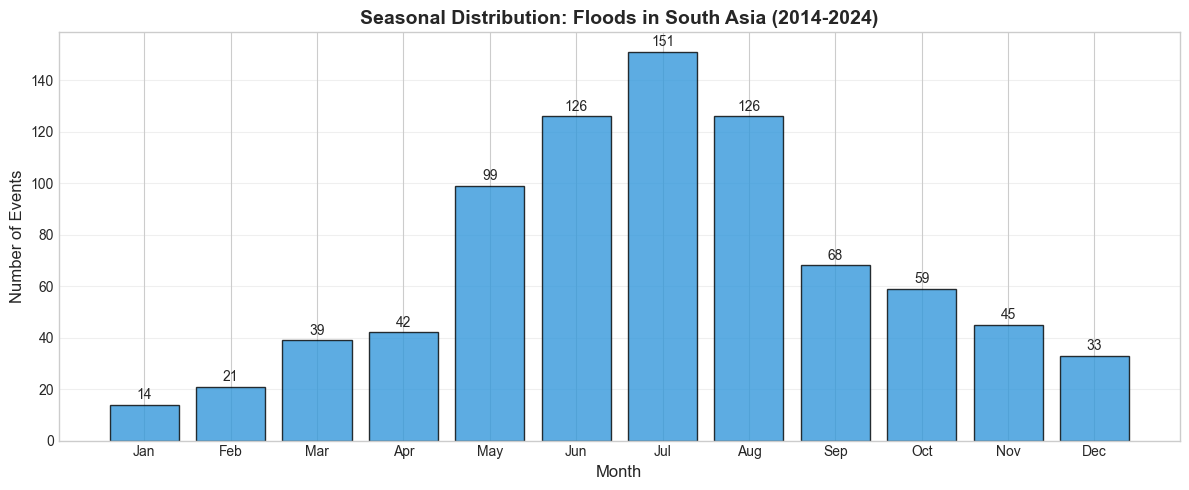

Peak month: Jul (151 events)


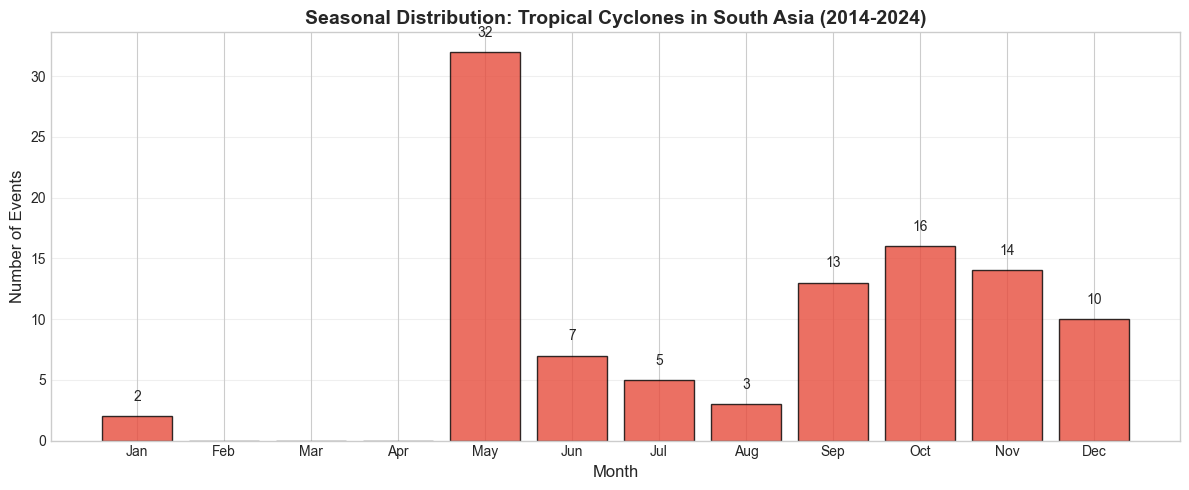

Peak month: May (32 events)


In [10]:
# ============================================================================
# SEASONALITY ANALYSIS: MONTHLY DISTRIBUTION
# ============================================================================

def plot_monthly_seasonality(df, title, color):
    """Plot monthly distribution of events."""
    if df.empty:
        print(f"No data for {title}")
        return
    
    df_copy = df.copy()
    df_copy['month'] = df_copy.index.month
    monthly_counts = df_copy.groupby('month').size().reindex(range(1, 13), fill_value=0)
    
    plt.figure(figsize=(12, 5))
    bars = plt.bar(monthly_counts.index, monthly_counts.values, color=color, edgecolor='black', alpha=0.8)
    
    # Add value labels
    for bar, val in zip(bars, monthly_counts.values):
        if val > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                    str(val), ha='center', va='bottom', fontsize=10)
    
    plt.title(f"Seasonal Distribution: {title} ({START_DATE.year}-{END_DATE.year})", fontsize=14, fontweight='bold')
    plt.xlabel("Month", fontsize=12)
    plt.ylabel("Number of Events", fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                              'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Peak months
    peak_month = monthly_counts.idxmax()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    print(f"Peak month: {month_names[peak_month-1]} ({monthly_counts[peak_month]} events)")

# Plot seasonality
print("\n" + "="*70)
print("SEASONALITY ANALYSIS")
print("="*70)

plot_monthly_seasonality(df_floods, "Floods in South Asia", "#3498db")
plot_monthly_seasonality(df_cyclones, "Tropical Cyclones in South Asia", "#e74c3c")

## 10. STL Time Series Decomposition


STL DECOMPOSITION


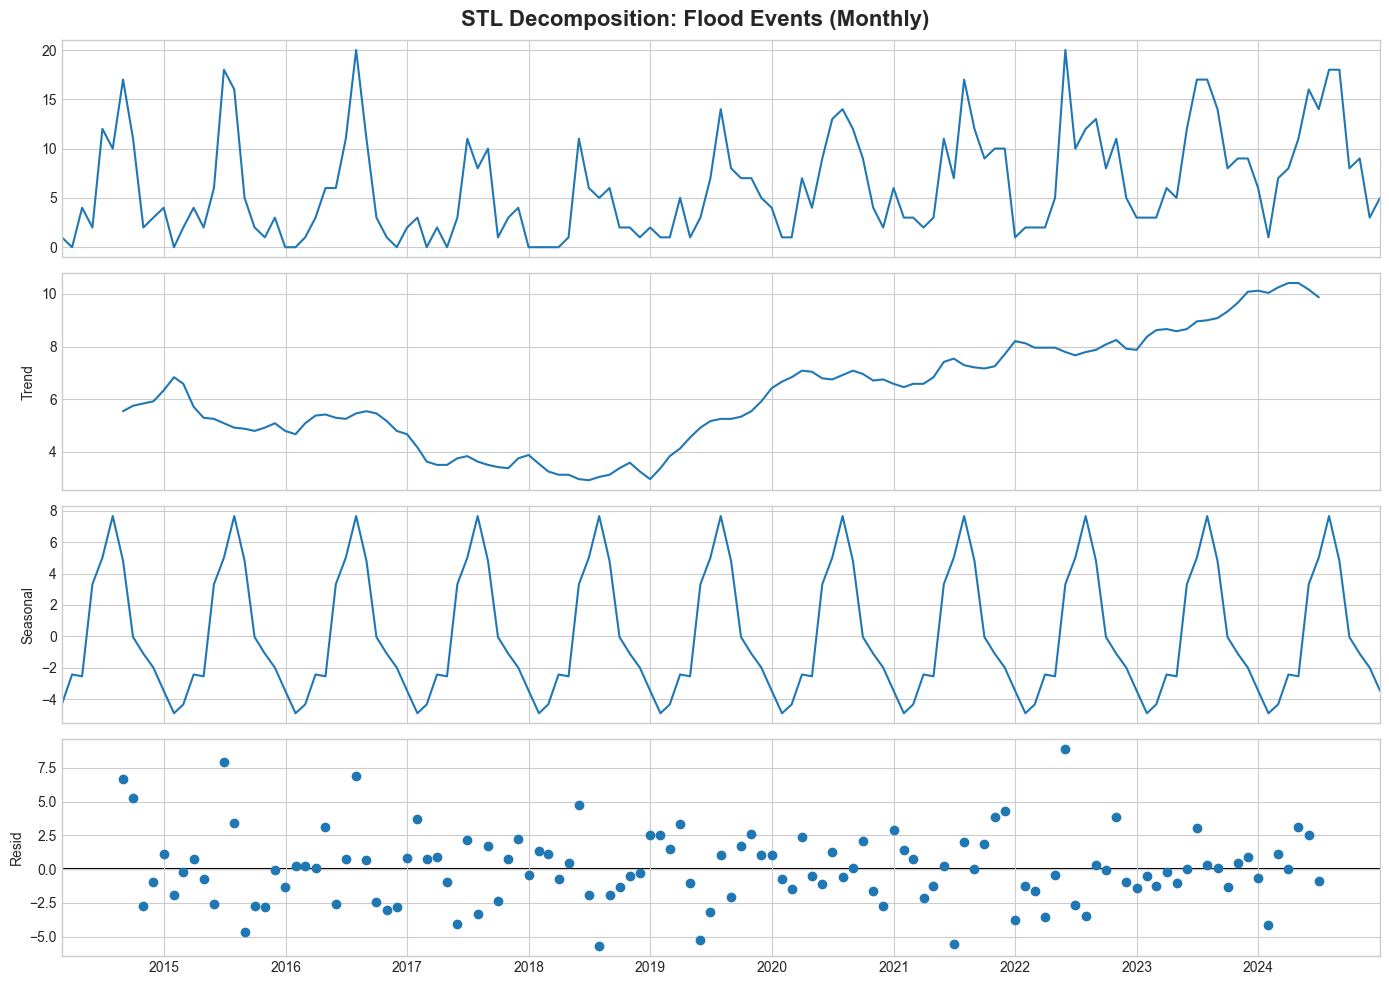


📈 Flood Events (Monthly) - Decomposition Insights:
   Trend range: 2.9 to 10.4
   Seasonal amplitude: 12.6


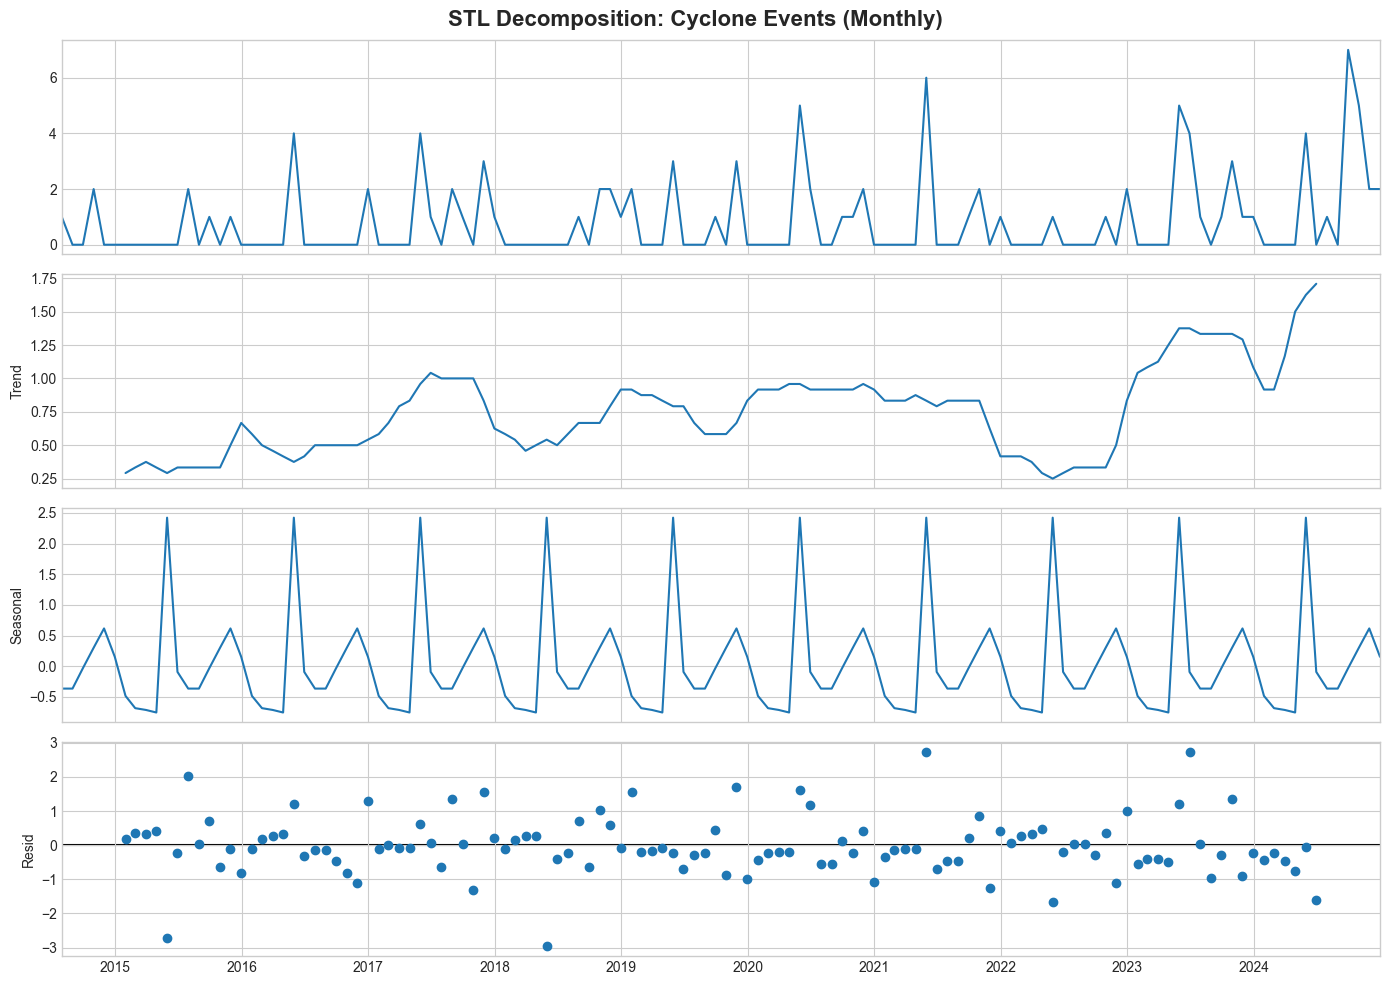


📈 Cyclone Events (Monthly) - Decomposition Insights:
   Trend range: 0.2 to 1.7
   Seasonal amplitude: 3.2


In [11]:
# ============================================================================
# STL DECOMPOSITION: TREND + SEASONALITY + RESIDUALS
# ============================================================================

def decompose_time_series(df, title, freq='M'):
    """Perform STL decomposition on time series data."""
    if df.empty:
        print(f"No data for {title}")
        return
    
    # Resample to monthly counts
    ts = df.resample(freq).size().fillna(0)
    
    if len(ts) < 24:
        print(f"Not enough data for STL decomposition (need 24+ months, got {len(ts)})")
        plt.figure(figsize=(12, 4))
        ts.plot(marker='o', linewidth=2)
        plt.title(f"Time Series: {title}")
        plt.ylabel("Events per Month")
        plt.grid(alpha=0.3)
        plt.show()
        return
    
    # Perform decomposition
    decomposition = seasonal_decompose(ts, model='additive', period=12)
    
    fig = decomposition.plot()
    fig.set_size_inches(14, 10)
    fig.suptitle(f'STL Decomposition: {title}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print(f"\n📈 {title} - Decomposition Insights:")
    print(f"   Trend range: {decomposition.trend.min():.1f} to {decomposition.trend.max():.1f}")
    print(f"   Seasonal amplitude: {(decomposition.seasonal.max() - decomposition.seasonal.min()):.1f}")

print("\n" + "="*70)
print("STL DECOMPOSITION")
print("="*70)

decompose_time_series(df_floods, "Flood Events (Monthly)")
decompose_time_series(df_cyclones, "Cyclone Events (Monthly)")

## 11. Country-Level Analysis


COUNTRY-LEVEL DISTRIBUTION


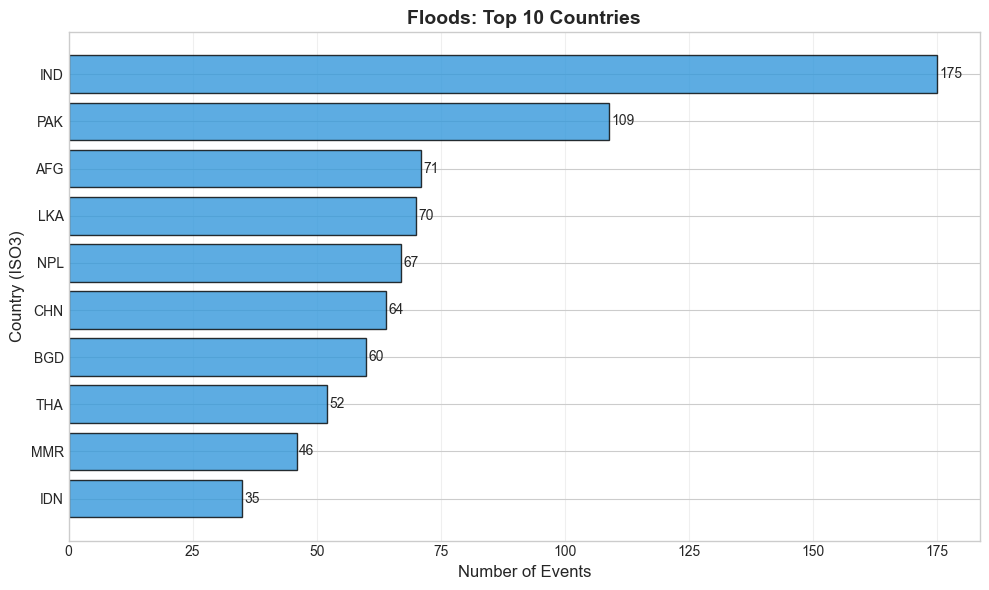

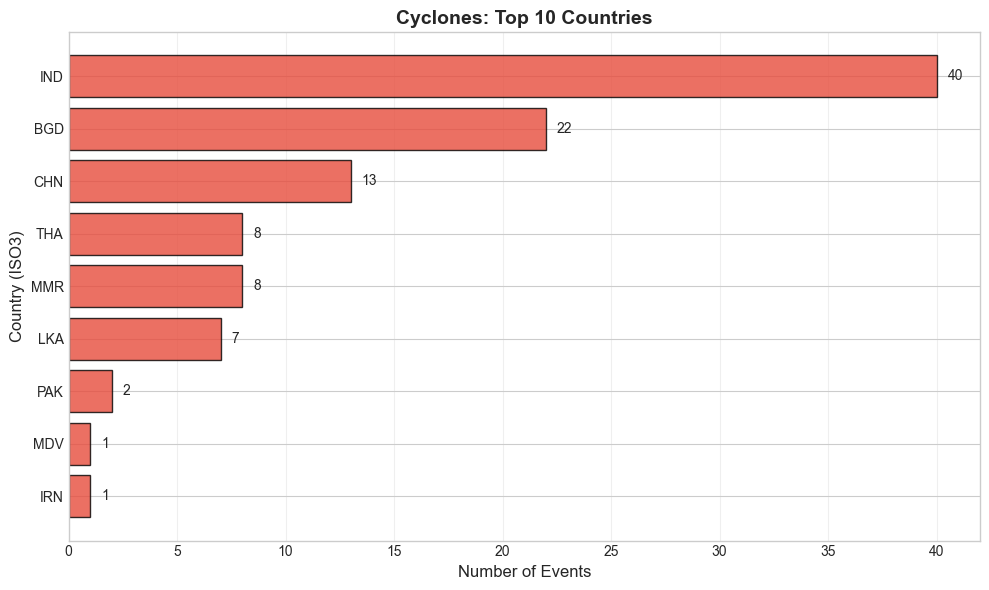

In [12]:
# ============================================================================
# COUNTRY-LEVEL ANALYSIS
# ============================================================================

def plot_country_distribution(df, title, color):
    """Plot events by country."""
    if df.empty:
        print(f"No data for {title}")
        return
    
    country_counts = df['primary_country'].value_counts().head(10)
    
    plt.figure(figsize=(10, 6))
    bars = plt.barh(country_counts.index, country_counts.values, color=color, edgecolor='black', alpha=0.8)
    
    # Add value labels
    for bar, val in zip(bars, country_counts.values):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                str(val), ha='left', va='center', fontsize=10)
    
    plt.title(f"{title}: Top 10 Countries", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Events", fontsize=12)
    plt.ylabel("Country (ISO3)", fontsize=12)
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return country_counts

print("\n" + "="*70)
print("COUNTRY-LEVEL DISTRIBUTION")
print("="*70)

floods_by_country = plot_country_distribution(df_floods, "Floods", "#3498db")
cyclones_by_country = plot_country_distribution(df_cyclones, "Cyclones", "#e74c3c")

## 12. Yearly Trend Analysis


YEARLY TREND ANALYSIS


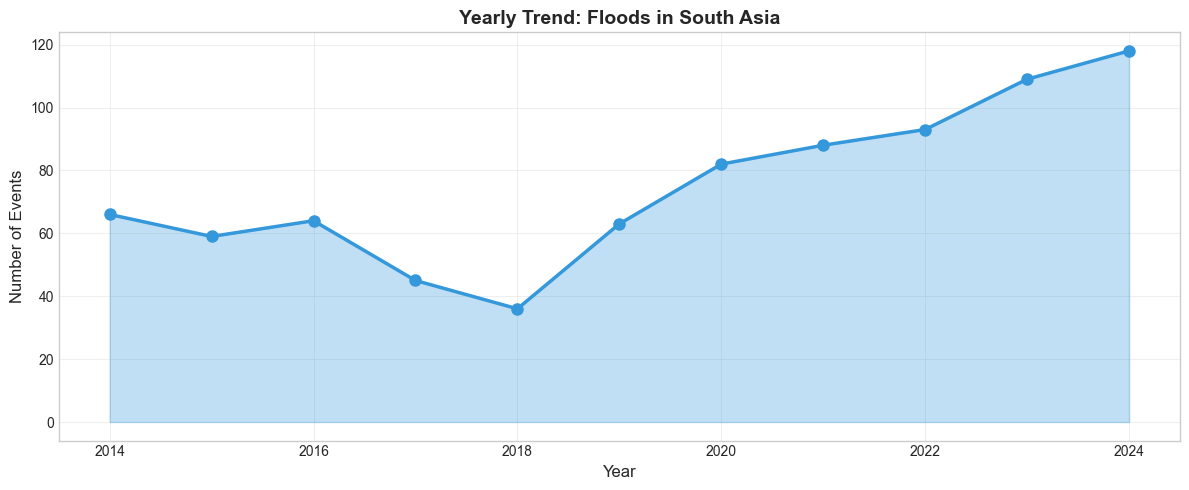


📈 MANN-KENDALL TREND TEST: Floods in South Asia
   Trend: INCREASING
   P-value: 0.0127 (Significant at 0.05)
   Slope: 6.25 events/year
   Total events: 823
   Average per year: 74.8


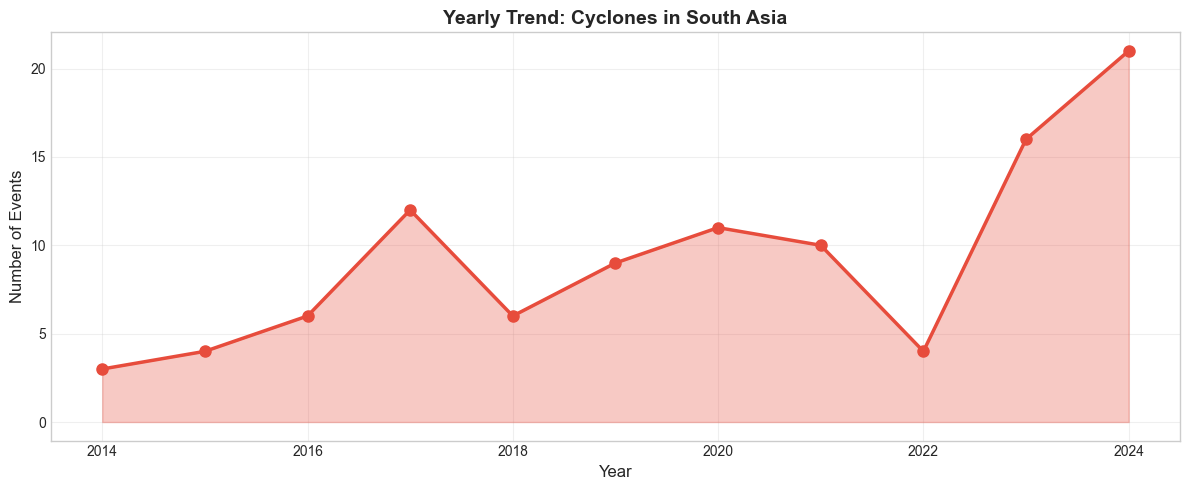


📈 MANN-KENDALL TREND TEST: Cyclones in South Asia
   Trend: INCREASING
   P-value: 0.0188 (Significant at 0.05)
   Slope: 1.33 events/year
   Total events: 102
   Average per year: 9.3


In [13]:
# ============================================================================
# YEARLY TREND ANALYSIS
# ============================================================================

def analyze_yearly_trend(df, title, color):
    """Analyze yearly trend with Mann-Kendall test."""
    if df.empty:
        print(f"No data for {title}")
        return
    
    # Yearly counts
    df_copy = df.copy()
    df_copy['year'] = df_copy.index.year
    yearly_counts = df_copy.groupby('year').size()
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2.5, 
            markersize=8, color=color, label=title)
    ax.fill_between(yearly_counts.index, yearly_counts.values, alpha=0.3, color=color)
    
    ax.set_title(f"Yearly Trend: {title}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Number of Events", fontsize=12)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mann-Kendall Trend Test
    if len(yearly_counts) >= 3:
        result = mk.original_test(yearly_counts.values)
        trend_emoji = "📈" if result.trend == "increasing" else "📉" if result.trend == "decreasing" else "➡️"
        
        print(f"\n{trend_emoji} MANN-KENDALL TREND TEST: {title}")
        print(f"   Trend: {result.trend.upper()}")
        print(f"   P-value: {result.p:.4f} {'(Significant at 0.05)' if result.p < 0.05 else '(Not significant)'}")
        print(f"   Slope: {result.slope:.2f} events/year")
        print(f"   Total events: {yearly_counts.sum()}")
        print(f"   Average per year: {yearly_counts.mean():.1f}")

print("\n" + "="*70)
print("YEARLY TREND ANALYSIS")
print("="*70)

analyze_yearly_trend(df_floods, "Floods in South Asia", "#3498db")
analyze_yearly_trend(df_cyclones, "Cyclones in South Asia", "#e74c3c")

## 13. Comparative Analysis: Floods vs Cyclones


COMPARATIVE ANALYSIS: FLOODS vs CYCLONES


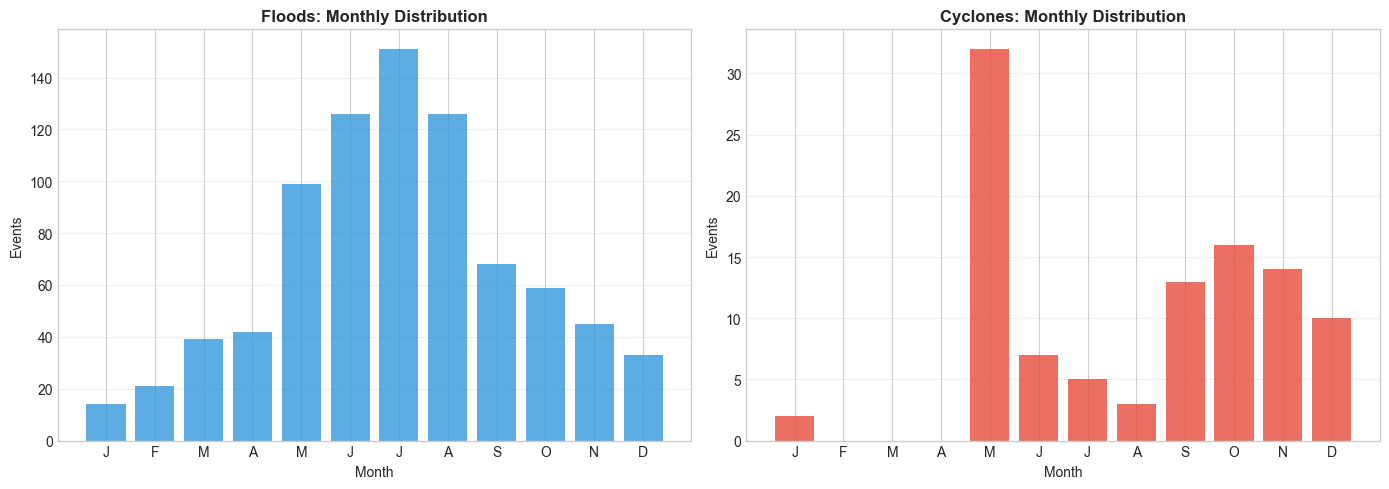


SUMMARY STATISTICS

Metric                                  Floods        Cyclones
------------------------------------------------------------
Total Events                               823             102
Countries Affected                          16
Peak Month                                 Jul
Countries Affected                                           9
Peak Month                                                 May


In [14]:
# ============================================================================
# COMPARATIVE ANALYSIS: FLOODS vs CYCLONES
# ============================================================================

print("\n" + "="*70)
print("COMPARATIVE ANALYSIS: FLOODS vs CYCLONES")
print("="*70)

# Monthly comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Floods monthly
if not df_floods.empty:
    df_floods_copy = df_floods.copy()
    df_floods_copy['month'] = df_floods_copy.index.month
    floods_monthly = df_floods_copy.groupby('month').size().reindex(range(1, 13), fill_value=0)
    axes[0].bar(floods_monthly.index, floods_monthly.values, color='#3498db', alpha=0.8, label='Floods')
    axes[0].set_title('Floods: Monthly Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Events')
    axes[0].set_xticks(range(1, 13))
    axes[0].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    axes[0].grid(axis='y', alpha=0.3)

# Cyclones monthly
if not df_cyclones.empty:
    df_cyclones_copy = df_cyclones.copy()
    df_cyclones_copy['month'] = df_cyclones_copy.index.month
    cyclones_monthly = df_cyclones_copy.groupby('month').size().reindex(range(1, 13), fill_value=0)
    axes[1].bar(cyclones_monthly.index, cyclones_monthly.values, color='#e74c3c', alpha=0.8, label='Cyclones')
    axes[1].set_title('Cyclones: Monthly Distribution', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Events')
    axes[1].set_xticks(range(1, 13))
    axes[1].set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"\n{'Metric':<30} {'Floods':>15} {'Cyclones':>15}")
print("-"*60)
print(f"{'Total Events':<30} {len(df_floods):>15} {len(df_cyclones):>15}")

if not df_floods.empty:
    print(f"{'Countries Affected':<30} {df_floods['primary_country'].nunique():>15}")
    print(f"{'Peak Month':<30} {['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][floods_monthly.idxmax()-1]:>15}")
if not df_cyclones.empty:
    print(f"{'Countries Affected':<30} {'':<15} {df_cyclones['primary_country'].nunique():>15}")
    print(f"{'Peak Month':<30} {'':<15} {['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][cyclones_monthly.idxmax()-1]:>15}")

print("="*70)

## 14. Conclusion

### Key Findings:

1. **Floods in South Asia:**
   - Peak during monsoon season (June-September)
   - India, Bangladesh, and Pakistan most affected
   - Shows seasonal pattern linked to Southwest Monsoon

2. **Tropical Cyclones in South Asia:**
   - Two cyclone seasons: Pre-monsoon (April-May) and Post-monsoon (October-November)
   - Bay of Bengal is primary cyclone formation region
   - India and Bangladesh most affected

### Technical Implementation:
- ✅ **CQL2-JSON server-side filtering** using `a_overlaps` operator for array fields
- ✅ **Memory-efficient** year-by-year CSV streaming
- ✅ **Proper hazard taxonomy** from GLIDE, EM-DAT, and UNDRR-ISC 2025
- ✅ **Statistical analysis** with STL decomposition and Mann-Kendall trend test

### Data Sources:
- GDACS Events
- EM-DAT Events
- GLIDE Events

---
*Data source: Montandon STAC API - https://montandon-eoapi-stage.ifrc.org/stac*

In [ ]:
# End of notebook